In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [116]:
G = 39.319

class SpaceTraversal:
    def __init__(self, x, v, m, r, action_space, B, h=1e-2, max_step = 200):
        """
        x: initial positions, 2D array, [[]], first item being the spaceship
        v: initial velocities, 2D array, [[]], first item being the spaceship
        m: mass, list, [], first item being the spaceship
        r: radius of planets, list, []
        action_space: possible actions, change in velocity of the spaceship, [[]]
        B: destination, []
        h: time step, float
        """
        self.m = m
        self.xStart, self.vStart = x, v
        self.x, self.v = x, v
        self.r = r
        self.action_space = action_space
        self.n_A = action_space.shape[0]
        self.B = B
        self.c = self.calc_dist(x[0], B)
        self.h = h
        self.max_step = max_step
        self.cur_step = 0
        initial_rx = self.x[0][0]
        initial_ry = self.x[0][1]
        self.trajectory = ([initial_rx],[initial_ry])
    
    def calc_dist(self, p1, p2):
        """
        returns the euclidean distance between p1 and p2
        """
        return np.linalg.norm(p1-p2)
        
    def calc_acc(self, x, m):
        """
        calculate accelerations w.r.t. postions x and masses m
        """
        N, dim = x.shape[0], x.shape[1]
        a = np.zeros(N*dim).reshape(N, dim)
        for i in range(N):
            x_prime = np.delete(x, i, 0)
            m_prime = np.delete(m, i)
            rel_pos = x_prime - x[i]
            dist = np.sqrt(abs(np.sum(rel_pos**2,1)))
            a[i] = np.sum(rel_pos.T * (1 / dist**3) * m_prime, 1)
        return G * a

    def reset(self):
        """
        reset the environment to its initial stage
        """
        self.x, self.v = self.xStart, self.vStart
        self.cur_step = 0
        self.trajectory = ([self.x[0][0]],[self.x[0][1]])
        obs = np.concatenate((self.x[0], self.v[0]), axis=None)
        return obs
    
    def random_action(self):
        """
        return the id of a random action
        """
        return np.random.randint(self.n_A)
    
    def step(self, action_id, test = False):
        """
        evolve one time step according to h and action
        """
        r_t = self.x[0]
        a = self.calc_acc(self.x, self.m)
        self.v = self.v + self.h * a
        self.v[0] = self.v[0] + self.action_space[action_id]
        self.x = self.x + self.h * self.v
        r_cur = self.x[0]
        
        # prev_dist = self.calc_dis(r_t, self.B)
        prev_dist = self.calc_dist(r_t, self.B)
        # cur_dist = dist(r_next, B)
        cur_dist = self.calc_dist(r_cur, self.B)
        # observation = (r_x, r_y, v_x, v_y)
        obs = np.concatenate((self.x[0], self.v[0]), axis=None)
        # reward = 1/c * [dist(r_t, B) - dist(r_t+1, B)]
        rwd = 1/self.c * (prev_dist - cur_dist) 
        # done
        # test if the spaceship arrive at B
        done = False
        msg = ""
        if cur_dist < 1:
            done = True
            msg = "success"
        # test if the spaceship crashes    
        n_object = self.x.shape[0] - 1
        i = 1
        while i <= n_object:
            obj_dist = self.calc_dist(r_cur, self.x[i])
            if obj_dist <= self.r[i-1]:
                done = True
                rwd = -10
                msg = "Bump onto object {}".format(i)
                break
            i += 1
        # test if the maximum step is exceeded
        self.cur_step += 1
        if self.cur_step == self.max_step:
            done = True
            rwd = -10
            msg = "Your spaceship flew away..."
        # append trajectory if testing
        if test:
            self.trajectory[0].append(self.x[0][0])
            self.trajectory[1].append(self.x[0][1])
            
        return obs, rwd, done, cur_dist, msg
        

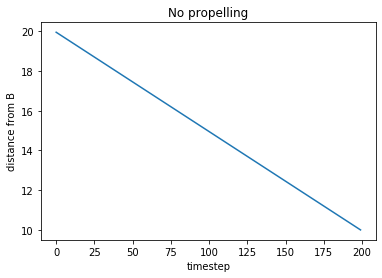

In [117]:
# A smmall test

x = np.array([[0,0]])
v = np.array([[5,0]])
m = np.array([4])
r = np.array([])
action_space = np.array([[0,1], [0, -1], [0, 0]])
B = np.array([20,0])

hk = SpaceTraversal(x, v, m, r, action_space, B)
# not propelling at all
obs, rwd, done, cur_dist = None, None, False, None
dist_history = []
while not done:
    obs, rwd, done, cur_dist, _ = hk.step(2)
    dist_history.append(cur_dist)
plt.plot(dist_history)
plt.title("No propelling")
plt.xlabel("timestep")
plt.ylabel("distance from B")
plt.show()

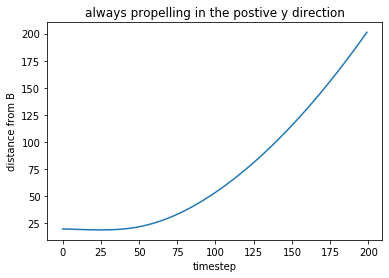

In [118]:
# always propelling in the postive y direction
# expecting the spaceship to fly away
hk.reset()
obs, rwd, done, cur_dist = None, None, False, None
dist_history = []
while not done:
    obs, rwd, done, cur_dist, _ = hk.step(0)
    dist_history.append(cur_dist)
plt.plot(dist_history)
plt.title("always propelling in the postive y direction")
plt.xlabel("timestep")
plt.ylabel("distance from B")
plt.show()

In [119]:
class QLSolver:
    def __init__(self, discrete_dim, discrete_range, environment):
        """
        intialize the object by computing the discretized
        thresholds for each var_numiable including position,
        veloccity, and acceleration
        """
        n = len(discrete_dim)
        discrete_space = []
        for i in range(n):
            high, low = discrete_range[i] # get upper and lower bounds
            dim = discrete_dim[i] # output dimension
            interval = (high-low)/dim # calculate interval
            # create a list of upper thresholds for each discretized value
            space = [low + (j+1)*interval for j in range(dim)]         
            discrete_space.append(space)
        
        self.n_var = n
        self.discrete_space = discrete_space
        self.discrete_dim = discrete_dim
        self.env = environment
        self.n_A = environment.action_space.shape[0]
        self.Q = np.zeros(discrete_dim+(self.n_A,))
    
    def transformObs(self, obs):
        """
        Given an observation of continuous values,
        discretize the values according to our initialization
        """
        state = np.zeros(self.n_var, dtype = np.int16)
        for var_num in range(self.n_var):
             # initialize each discrete state to be the highest value
            discrete_val = self.discrete_dim[var_num]-1
            value = obs[var_num]
            space_threshold = self.discrete_space[var_num]
            n_dim = self.discrete_dim[var_num]
            for dim in range(n_dim):
                if value < space_threshold[dim]:
                    discrete_val = dim
                    break
            state[var_num] = discrete_val
        return tuple(state)
    
    def train(self, max_itr = 300, min_itr = 100,  break_if_success = False,
              alpha_floor = 0.05, e_floor = 0.05, eta = 0.05, gamma = 1):
        """
        train the model based on Q-Learning
        
        params:
            max_itr: maximum iteration
            min_itr: minimum iteration, only useful if break_if_success = True
            break_if_success: break immediately if the model arrives at the target
            alpha_floor: minimum alpha value (learning rate)
            e_floor: minimum epsilon value (the probability of randomly picking an action)
            eta: the adaptive rate for which alpha and epsilon decreases
            gamma: discounted factor for future rewards, 0< gamma <=1;
                   gamma=1 means consider only next step
        """
        dist_his = []
        for episode in range(max_itr):
            alpha = max(alpha_floor,  0.1-math.log10((episode + 1) * eta))
            e = max(e_floor, 0.8 - math.log10((episode + 1) * eta ))
            done = False
            state = self.transformObs(self.env.reset())
            while not done:
                action = np.argmax(self.Q[state])
                if (np.random.random() <= e):
                    action = self.env.random_action()
                obs, rwd, done, cur_dist, msg = self.env.step(action)
                newState = self.transformObs(obs)
                oldQ = self.Q[state][action]
                self.Q[state][action] += alpha * (rwd + gamma * np.max(self.Q[newState]) - oldQ)
                state = newState
            dist_his.append(cur_dist)
            if (episode+1) % 100 == 0:
                print(episode+1, cur_dist)
            if break_if_success and msg=='success' and episode>min_itr:
                break
        return dist_his
    
    def run(self):
        state = self.transformObs(self.env.reset())
        cur_dist = None
        done = False
        action_his = []
        while not done:
            action = np.argmax(self.Q[state])
            obs, _, done, cur_dist, msg = self.env.step(action, test=True)
            state = self.transformObs(obs)
            action_his.append(action)
        print("final distance: %.2f, %s" % (cur_dist, msg))
        return action_his

### Trial #1: No Gravitational Objects

In [6]:
x = np.array([[0,0]])
v = np.array([[5,0]])
m = np.array([4])
r = np.array([])
action_space = np.array([[0,1e-2], [0, -1e-2], [0, 0]])
B = np.array([20,0])

hitchhiker = SpaceTraversal(x, v, m, r, action_space, B, max_step = 500)
# rx, ry, vx, vy
n_State = (3, 3, 3, 3)
discrete_range = [(-10,10), (-10,10), (-10,10), (-10,10)]
solver = QLSolver(n_State, discrete_range, hitchhiker)
dist_his = solver.train(max_itr=500, min_itr=200, gamma = 0.5, break_if_success=True)

100 11.606324603852904
200 7.690979600155104


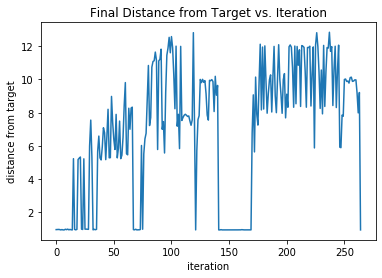

In [7]:
plt.plot(dist_his)
plt.title("Final Distance from Target vs. Iteration")
plt.xlabel("iteration")
plt.ylabel("distance from target")
plt.show()

final distance: 1.00, success


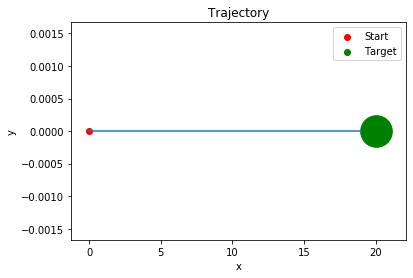

In [8]:
action_his = solver.run()
xs, ys = solver.env.trajectory
plt.plot(xs, ys)
plt.title('Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x[0][0], x[0][1], label = 'Start', c = 'r')
plt.scatter(B[0], B[1], label = 'Target', c = 'g')
plt.scatter(B[0], B[1], s = 1000, c = 'g')
plt.legend()
plt.show()

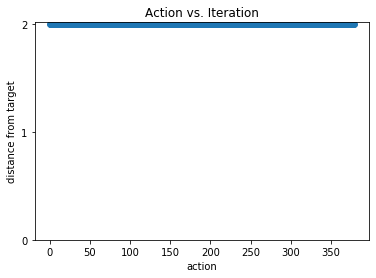

In [9]:
plt.scatter(range(len(action_his)), action_his)
plt.yticks([0,1,2])
plt.title("Action vs. Iteration")
plt.xlabel("action")
plt.ylabel("distance from target")
plt.show()

### Trial #2: One Gravitational Object

In [10]:
x = np.array([[0,0], [10, 5]])
v = np.array([[5,0], [0, 0]])
m = np.array([1e-10, 1])
r = np.array([1])
action_space = np.array([[0,1e-2], [0, -1e-2], [0, 0]])
B = np.array([20,10])

hitchhiker = SpaceTraversal(x, v, m, r, action_space, B, max_step = 500)
# rx, ry, vx, vy
n_State = (3, 3, 3, 3)
discrete_range = [(-10,10), (-10,10), (-10,10), (-10,10)]
solver = QLSolver(n_State, discrete_range, hitchhiker)
dist_his = solver.train(max_itr=1000, min_itr=300, gamma = 0.5, break_if_success=True)

100 0.9874408052481206
200 6.973334163129413
300 7.197712886267504


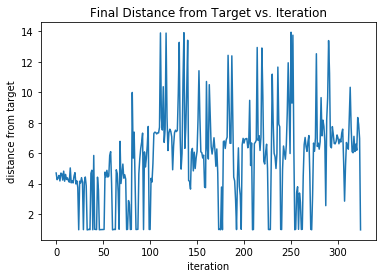

In [11]:
plt.plot(dist_his)
plt.title("Final Distance from Target vs. Iteration")
plt.xlabel("iteration")
plt.ylabel("distance from target")
plt.show()

final distance: 5.08, Maximum step exceeded. Your spaceship flew away...


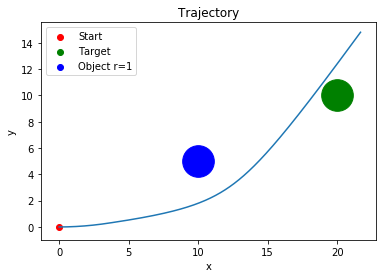

In [12]:
action_his = solver.run()
xs, ys = solver.env.trajectory
plt.plot(xs, ys)
plt.title('Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x[0][0], x[0][1], label = 'Start', c = 'r')
plt.scatter(B[0], B[1], label = 'Target', c = 'g')
plt.scatter(B[0], B[1], s = 1000, c = 'g')
n_object = r.shape[0]
for i in range(n_object):
    plt.scatter(x[i+1][0], x[i+1][1], label = 'Object r={}'.format(r[i]), c = 'b')
    plt.scatter(x[i+1][0], x[i+1][1], s = r[i]*1000, c = 'b')
plt.legend()
plt.show()

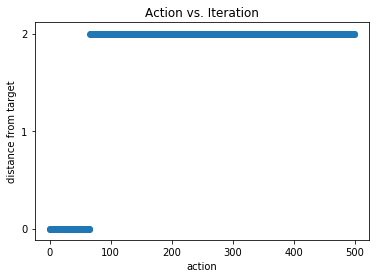

In [13]:
plt.scatter(range(len(action_his)), action_his)
plt.yticks([0,1,2])
plt.title("Action vs. Iteration")
plt.xlabel("action")
plt.ylabel("distance from target")
plt.show()

### Trial #3: Two Gravitational Objeccts

In [40]:
x = np.array([[0,0], [15, 10], [10, -10]])
v = np.array([[5,0], [0, 0], [0, 0]])
m = np.array([1e-10, 1, 0.5])
r = np.array([1, 2])
action_space = np.array([[0,1e-2], [0, -1e-2], [0, 0]])
B = np.array([25,0])

hitchhiker = SpaceTraversal(x, v, m, r, action_space, B, max_step = 500)
# rx, ry, vx, vy
n_State = (3, 3, 3, 3)
discrete_range = [(-10,10), (-10,10), (-10,10), (-10,10)]
solver = QLSolver(n_State, discrete_range, hitchhiker)
dist_his = solver.train(max_itr=1000, min_itr=800, gamma = 0.5, break_if_success=True)

100 5.956612538620816
200 11.348995126300485
300 7.322669761727153
400 0.9910006672946418
500 11.268641377372358
600 6.538711526246836
700 9.5169760581913
800 6.842554699315345


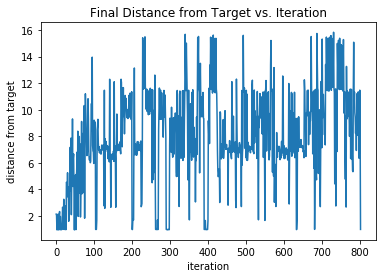

In [41]:
plt.plot(dist_his)
plt.title("Final Distance from Target vs. Iteration")
plt.xlabel("iteration")
plt.ylabel("distance from target")
plt.show()

final distance: 0.99, success


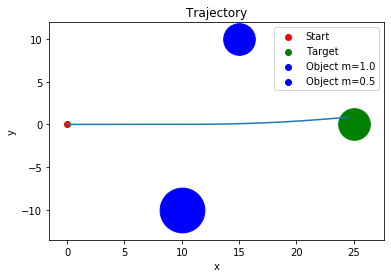

In [44]:
action_his = solver.run()
xs, ys = solver.env.trajectory
plt.plot(xs, ys)
plt.title('Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x[0][0], x[0][1], label = 'Start', c = 'r')
plt.scatter(B[0], B[1], label = 'Target', c = 'g')
plt.scatter(B[0], B[1], s = 1000, c = 'g')
n_object = r.shape[0]
for i in range(n_object):
    plt.scatter(x[i+1][0], x[i+1][1], label = 'Object m={}'.format(m[i+1]), c = 'b')
    plt.scatter(x[i+1][0], x[i+1][1], s = r[i]*1000, c = 'b')
plt.legend()
plt.show()

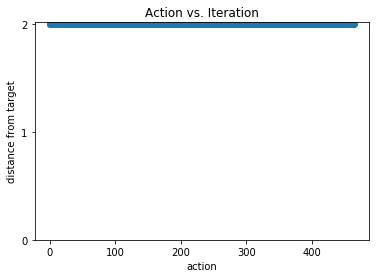

In [45]:
plt.scatter(range(len(action_his)), action_his)
plt.yticks([0,1,2])
plt.title("Action vs. Iteration")
plt.xlabel("action")
plt.ylabel("distance from target")
plt.show()

### Trial #4: Gravitational Object on the Way!

In [122]:
x = np.array([[0,0], [10, 0]])
v = np.array([[5,0], [0, 0]])
m = np.array([1e-10, 1])
r = np.array([1])
action_space = np.array([[0,10], [0, -10], [0,1], [0, -1], [0, 0]])
B = np.array([25,0])

hitchhiker = SpaceTraversal(x, v, m, r, action_space, B, max_step = 500)
# rx, ry, vx, vy
n_State = (3, 3, 3, 3)
discrete_range = [(-10,10), (-10,10), (-10,10), (-10,10)]
solver = QLSolver(n_State, discrete_range, hitchhiker)
dist_his = solver.train(max_itr=1000, min_itr=800, gamma = 0.5, break_if_success=True)

100 474.72913378264667
200 4.362224658334205
300 3667.116876487812
400 0.9771864309320335
500 308.60953283712064
600 54.351724760772235
700 111.02866739576538
800 4.106767038755479


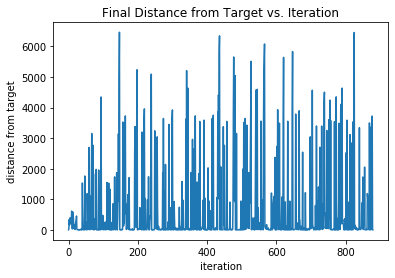

In [123]:
plt.plot(dist_his)
plt.title("Final Distance from Target vs. Iteration")
plt.xlabel("iteration")
plt.ylabel("distance from target")
plt.show()

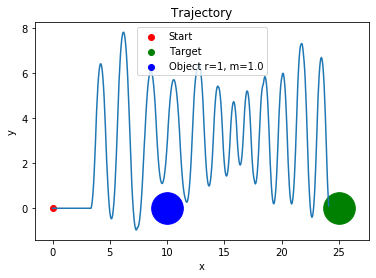

In [114]:
action_his = solver.run()
xs, ys = solver.env.trajectory
plt.plot(xs, ys)
plt.title('Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x[0][0], x[0][1], label = 'Start', c = 'r')
plt.scatter(B[0], B[1], label = 'Target', c = 'g')
plt.scatter(B[0], B[1], s = 1000, c = 'g')
n_object = r.shape[0]
for i in range(n_object):
    plt.scatter(x[i+1][0], x[i+1][1], label = 'Object r={}, m={}'.format(r[i], m[i+1]), c = 'b')
    plt.scatter(x[i+1][0], x[i+1][1], s = r[i]*1000, c = 'b')
plt.legend()
plt.show()

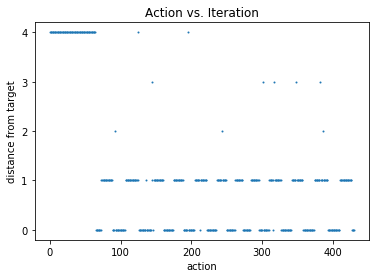

In [115]:
plt.scatter(range(len(action_his)), action_his, s=1)
plt.yticks([0,1,2,3,4])
plt.title("Action vs. Iteration")
plt.xlabel("action")
plt.ylabel("distance from target")
plt.show()